# Machine Learning Models for APS failure

In [24]:
# Importing all the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV,KFold
from sklearn.metrics import confusion_matrix,f1_score,log_loss,roc_curve,recall_score,precision_score,fbeta_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm
from imblearn import over_sampling
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [2]:
# Reading the train and test dataset where missing values are imputed using median
X_train = pd.read_csv("X_train.csv")
X_test = pd.read_csv("X_test.csv")
y_train = pd.read_csv("y_train.csv")
y_test = pd.read_csv("y_test.csv")

In [3]:
X_train.drop(['Unnamed: 0'],axis = 1,inplace = True)
X_test.drop(['Unnamed: 0'],axis = 1,inplace = True)
y_train.drop(['Unnamed: 0'],axis = 1,inplace = True)
y_test.drop(['Unnamed: 0'],axis = 1,inplace = True)

<AxesSubplot:xlabel='class', ylabel='count'>

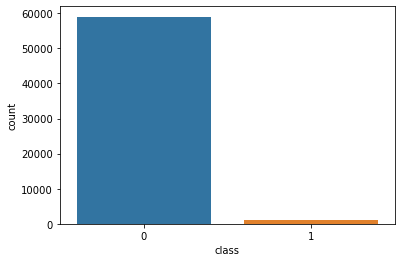

In [137]:
sns.countplot(x= y_train["class"])

Class imbalance is a scenario that arises when we have unequal distribution of class in a dataset i.e. the no. of data points in the negative class (majority class) very large compared to that of the positive class (minority class).Generally, the minority/positive class is the class of interest and we aim to achieve the best results in this class rather. If the imbalanced data is not treated beforehand, then this will degrade the performance of the classifier model. Most of the predictions will correspond to the majority class and treat the minority class features as noise in the data and ignore them. This will result in a high bias in the model.

# Dealing with Imbalanced Data

Resampling data is one of the most commonly preferred approaches to deal with an imbalanced dataset. There are broadly two types of methods for this i) Undersampling ii) Oversampling. In most cases, oversampling is preferred over undersampling techniques. The reason being, in undersampling we tend to remove instances from data that may be carrying some important information. In this article, I am specifically covering some special data augmentation oversampling techniques: SMOTE and its related counterparts.

# SMOTE: Synthetic Minority Oversampling Technique

SMOTE is an oversampling technique where the synthetic samples are generated for the minority class. This algorithm helps to overcome the overfitting problem posed by random oversampling. It focuses on the feature space to generate new instances with the help of interpolation between the positive instances that lie together.

https://www.analyticsvidhya.com/blog/2020/10/overcoming-class-imbalance-using-smote-techniques/

In [144]:
#sm = SMOTE()
#X_train_new, y_train_new = sm.fit_sample(X_train, y_train)

In [4]:
from imblearn.combine import SMOTEENN
# oversampling the train dataset using SMOTE + ENN
smenn = SMOTEENN(random_state = 101)
X_train_new, y_train_new = smenn.fit_resample(X_train, y_train)

ML Pipeline is defined as a collection of preprocessing steps and a model. This means when raw data is passed to the ML Pipeline, it preprocesses the data to the right format, scores the data using the model and pops out a prediction score.

# I use standarisation of data , PCA and classification model with a pipeline

In [6]:
pipe_lr = Pipeline([('scl', StandardScaler()),('pca1',PCA(n_components=10)),
                    ('LR', LogisticRegression(random_state=42))])
pipe_dt = Pipeline([('scl', StandardScaler()),('pca2',PCA(n_components=10)),
                    ('DT',DecisionTreeClassifier(random_state=42))])
pipe_rf = Pipeline([('scl', StandardScaler()),('pca3',PCA(n_components=10)),
                    ('RF',RandomForestClassifier(random_state=42))])
pipe_svm = Pipeline([('scl', StandardScaler()),('pca4',PCA(n_components=10)),
                     ('SVM', svm.SVC(random_state=42))])
pipe_xgb = Pipeline([('scl', StandardScaler()),('pca5',PCA(n_components=10)),
                     ('XGB', XGBClassifier(random_state=42))])
pipe_AdaBoost = Pipeline([('scl', StandardScaler()),('pca6',PCA(n_components=10)),
                     ('ADA', AdaBoostClassifier(random_state=42))])
pipe_GradientBoosting = Pipeline([('scl', StandardScaler()),('pca7',PCA(n_components=10)),
                     ('GB', GradientBoostingClassifier(random_state=42))])

In [7]:
grids = [pipe_lr, pipe_dt, pipe_rf,pipe_svm, pipe_xgb,pipe_AdaBoost,pipe_GradientBoosting]
for pipe in grids:
    pipe.fit(X_train_new,y_train_new)

# Test Accuracy FOR Test Dataset

In [8]:
grid_dict = {0: 'Logistic Regression', 1: 'Decision Trees', 
             2: 'Random Forest',3: 'Support Vector Machines', 4: 'XGBoost',5:'AdaBoostClassifier',
             6:'GradientBoostingClassifier'}
for i, model in enumerate(grids):
    print('{} Test Accuracy: {:.2f}%'.format(grid_dict[i],model.score(X_test,y_test)*100))
    

Logistic Regression Test Accuracy: 95.58%
Decision Trees Test Accuracy: 96.63%
Random Forest Test Accuracy: 97.35%
Support Vector Machines Test Accuracy: 95.29%
XGBoost Test Accuracy: 97.32%
AdaBoostClassifier Test Accuracy: 94.11%
GradientBoostingClassifier Test Accuracy: 94.97%


# Detailed obsevations

In [87]:
#models = {pipe_lr: 'Logistic Regression', pipe_dt: 'Decision Trees'}
          

In [9]:
models = {pipe_lr: 'Logistic Regression', pipe_dt: 'Decision Trees', 
          pipe_rf: 'Random Forest',pipe_svm: 'Support Vector Machines', 
          pipe_xgb: 'XGBoost',pipe_AdaBoost:'AdaBoostClassifier',
          pipe_GradientBoosting:'GradientBoostingClassifier'}

In [10]:
result_df= pd.DataFrame()
model_name=[]
model_accuracy_score=[]
model_roc=[]
TC=[]
# train function fits the model and returns accuracy score
def train(algo,name,X_train,y_train,X_test,y_test):
    algo.fit(X_train,y_train)
    y_pred = algo.predict(X_test)
    score = accuracy_score(y_test,y_pred)
    print(f"--------------------------------------------{name}---------------------------------------------------")
    print(f"Accuracy Score for {name}: {score*100:.4f}%")
    return y_test,y_pred,score

# acc_res function calculates confusion matrix
def acc_res(y_test,y_pred,name):
    null_accuracy = y_test.value_counts()[0]/len(y_test)
    print(f"Null Accuracy: {null_accuracy*100:.4f}%")
    print("Confusion Matrix")
    matrix = confusion_matrix(y_test,y_pred)
    print(matrix)
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    TN = matrix[0,0]
    FP = matrix[0,1]
    FN = matrix[1,0]
    TP = matrix[1,1]
    accuracy_score=(TN+TP) / float(TP+TN+FP+FN)
    recall_score = (TP)/ float(TP+FN)
    specificity = TN / float(TN+FP)
    FPR = FP / float(FP+TN)
    precision_score = TP / float(TP+FP)
    roc_svc =roc_auc_score(y_test,y_pred)
    cost= 10*FP + 500*FN 
    global results_df,model_name,model_accuracy_score,model_roc
    model_name.extend([name])
    model_accuracy_score.extend([accuracy_score*100])
    model_roc.extend([roc_svc*100])
    TC.extend([cost])
    results_df = pd.DataFrame({
    'Model': model_name,
    'Accuracy': model_accuracy_score,
    'ROC': model_roc,
    'Total Cost':TC   
    }) 
    print(f"Accuracy Score: {accuracy_score*100:.4f}%")
    print(f"Recall Score: {recall_score*100:.4f}%")
    print(f"Specificity Score: {specificity*100:.4f}%")
    print(f"False Positive Rate: {FPR*100:.4f}%")
    print(f"Precision Score: {precision_score*100:.4f}%")
    print('ROC score:{0:0.2f}%'. format(roc_svc*100))
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print("Classification Report")
    print(classification_report(y_test,y_pred))
    
def main(models):
    accuracy_scores = []
    for algo,name in models.items():
        y_test_train,y_pred,acc_score = train(algo,name,X_train_new, y_train_new,X_test,y_test)
        acc_res(y_test_train,y_pred,name)
        accuracy_scores.append(acc_score)
    return accuracy_scores

In [16]:
accuracy_scores = main(models) 

--------------------------------------------Logistic Regression---------------------------------------------------
Accuracy Score for Logistic Regression: 95.5750%
Null Accuracy: 97.6562%
Confusion Matrix
[[14936   689]
 [   19   356]]
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Accuracy Score: 95.5750%
Recall Score: 94.9333%
Specificity Score: 95.5904%
False Positive Rate: 4.4096%
Precision Score: 34.0670%
ROC score:95.26%
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     15625
           1       0.34      0.95      0.50       375

    accuracy                           0.96     16000
   macro avg       0.67      0.95      0.74     16000
weighted avg       0.98      0.96      0.97     16000

--------------------------------------------Decision Trees---------------------------------------------------
Accur

In [17]:
result_df = results_df.sort_values(by='Accuracy', ascending=False)
result_df = result_df.set_index('Model')
result_df.reset_index()

,Model,Accuracy,ROC,Total Cost
0,Random Forest,97.28750,95.748267,15120
1,XGBoost,97.16875,95.166933,17270
2,Decision Trees,96.47500,92.078933,28670
3,Logistic Regression,95.57500,95.261867,16390
4,Support Vector Machines,95.28125,95.501867,15390
5,GradientBoostingClassifier,94.95000,95.722667,14450
6,AdaBoostClassifier,94.15625,95.186133,16210


In [18]:
result=pd.DataFrame(result_df.reset_index())
categorical_features = [feature for feature in result.columns if result[feature].dtype == 'O']

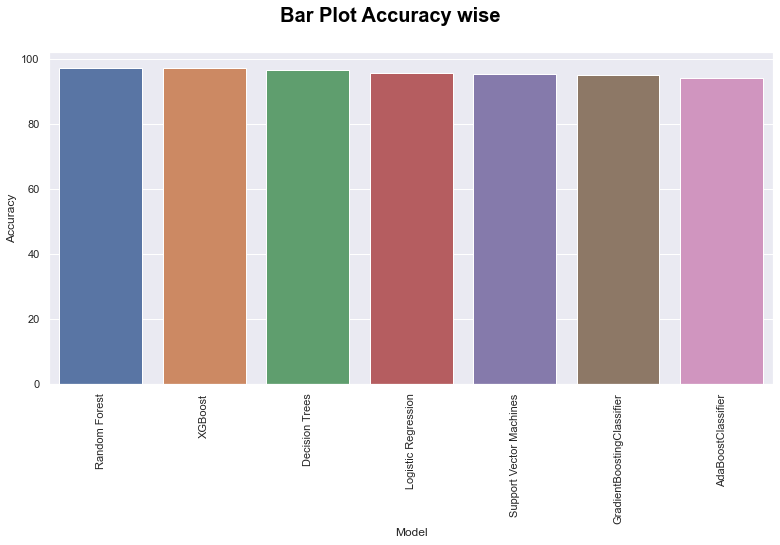

In [19]:
# Bar plot to see the relationship between categorical features and target
plt.figure(figsize=(11, 47))
plt.suptitle('Bar Plot Accuracy wise', fontsize=20, fontweight='bold', alpha=1, y=1)
sns.set(style = 'darkgrid', font_scale = 1)
for i in range(0, len(categorical_features)):
    plt.subplot(7, 1, i+1)
    sns.barplot(y='Accuracy', x=categorical_features[i], data=result)
    plt.xticks(rotation = 90)
    plt.tight_layout()

In [ ]:
df = result
fig = px.pie(df, values='ROC', names='Model',title='Pie Chart ROC Score wise')
labels=df['Model']
fig.update_traces(hoverinfo='label+percent', textinfo='label+value', textfont_size=15,
                  marker=dict(colors=colors, line=dict(color='#85C1E9', width=2)))
fig.update_layout(
    autosize=True,
    width=900,
    height=900,
    yaxis=dict(
        title_text="Y-axis Title",
        ticktext=["Very long label", "long label", "3", "label"],
        tickvals=[1, 2, 3, 4],
        tickmode="array",
        titlefont=dict(size=30),
    )
)
fig.show()

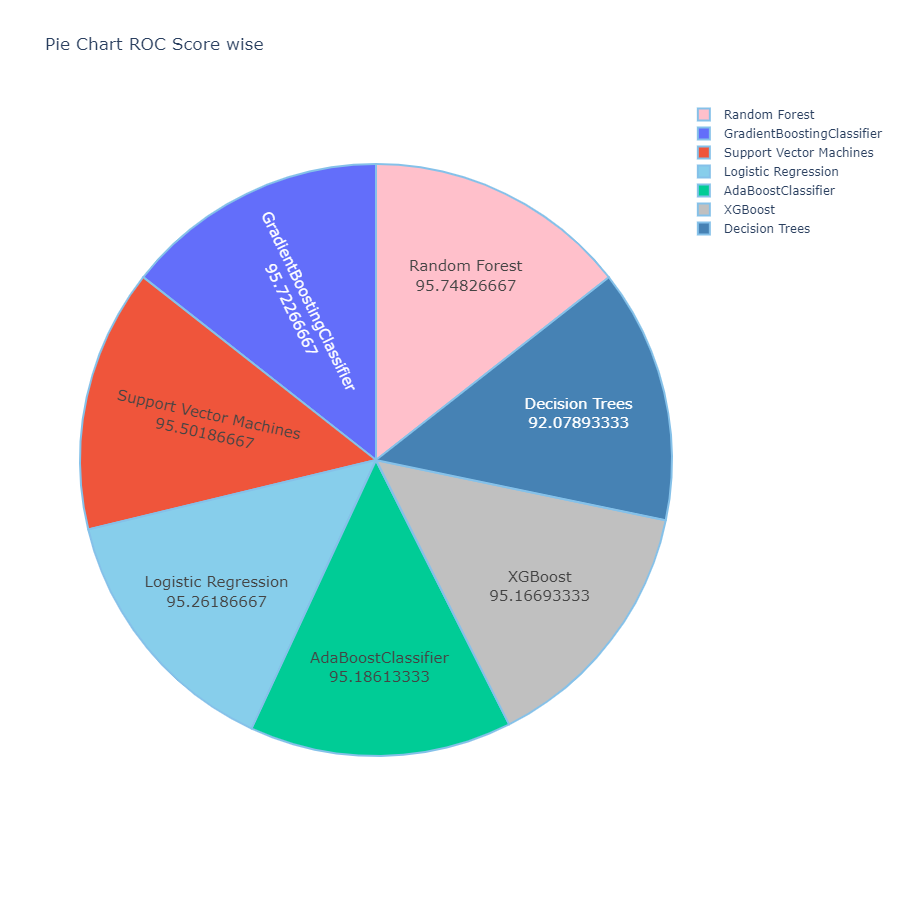

# Hyperparameter tuning

In [178]:
pipe_lr = Pipeline([('scl', StandardScaler()),('pca1',PCA(n_components=10)),
                    ('LR', LogisticRegression(random_state=42))])
pipe_dt = Pipeline([('scl', StandardScaler()),('pca2',PCA(n_components=10)),
                    ('DT',DecisionTreeClassifier(random_state=42))])
pipe_rf = Pipeline([('scl', StandardScaler()),('pca3',PCA(n_components=10)),
                    ('RF',RandomForestClassifier(random_state=42))])
pipe_svm = Pipeline([('scl', StandardScaler()),('pca4',PCA(n_components=10)),
                     ('SVM', svm.SVC(random_state=42))])
pipe_xgb = Pipeline([('scl', StandardScaler()),('pca5',PCA(n_components=10)),
                     ('XGB', XGBClassifier(random_state=42))])
pipe_AdaBoost = Pipeline([('scl', StandardScaler()),('pca6',PCA(n_components=10)),
                     ('ADA', AdaBoostClassifier(random_state=42))])
pipe_GradientBoosting = Pipeline([('scl', StandardScaler()),('pca7',PCA(n_components=10)),
                     ('GB', GradientBoostingClassifier(random_state=42))])

In [177]:
param_range = [1, 2, 3, 4, 5, 6]
param_range_fl = [1.0, 0.5, 0.1]
n_estimators = [50,100,150]
learning_rates = [.1,.2,.3]
lr_param_grid = [{'LR__penalty': ['l1', 'l2'],
                   'LR__C': param_range_fl,
                   'LR__solver': ['liblinear']}]
dt_param_grid = [{'DT__criterion': ['gini', 'entropy'],
                   'DT__min_samples_leaf': param_range,
                   'DT__max_depth': param_range,
                   'DT__min_samples_split': param_range[1:]}]
rf_param_grid = [{'RF__min_samples_leaf': param_range,
                   'RF__max_depth': param_range,
                   'RF__min_samples_split': param_range[1:]}]
svm_param_grid = [{'SVM__kernel': ['linear', 'rbf'], 
                    'SVM__C': param_range}]
xgb_param_grid = [{'XGB__learning_rate': learning_rates,
                    'XGB__max_depth': param_range,
                    'XGB__min_child_weight': param_range[:2],
                    'XGB__subsample': param_range_fl,
                    'XGB__n_estimators': n_estimators}]

In [176]:
lr_grid_search = RandomizedSearchCV(estimator=pipe_lr,
        param_distributions=lr_param_grid,
        scoring='accuracy',
        cv=3)
dt_grid_search = RandomizedSearchCV(estimator=pipe_dt,
        param_distributions=dt_param_grid,
        scoring='accuracy',
        cv=3)
rf_grid_search = RandomizedSearchCV(estimator=pipe_rf,
        param_distributions=rf_param_grid,
        scoring='accuracy',
        cv=3)
svm_grid_search = RandomizedSearchCV(estimator=pipe_svm,
        param_distributions=svm_param_grid,
        scoring='accuracy',
        cv=3)
xgb_grid_search = RandomizedSearchCV(estimator=pipe_xgb,
        param_distributions=xgb_param_grid,
        scoring='accuracy',
        cv=3)

In [212]:
grids = [lr_grid_search, dt_grid_search,rf_grid_search,xgb_grid_search]
for pipe in grids:
    pipe.fit(X_train_new,y_train_new)

In [213]:
grid_dict = {0: 'Logistic Regression', 1: 'Decision Trees', 
             2: 'Random Forest', 
             3: 'XGBoost'}
for i, model in enumerate(grids):
    print('{} Test Accuracy: {}'.format(grid_dict[i],
    model.score(X_test,y_test)))
    print('{} Best Params: {}'.format(grid_dict[i],model.best_params_))

Logistic Regression Test Accuracy: 0.9560625
Logistic Regression Best Params: {'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__C': 1.0}
Decision Trees Test Accuracy: 0.93975
Decision Trees Best Params: {'DT__min_samples_split': 3, 'DT__min_samples_leaf': 3, 'DT__max_depth': 4, 'DT__criterion': 'gini'}
Random Forest Test Accuracy: 0.94375
Random Forest Best Params: {'RF__min_samples_split': 2, 'RF__min_samples_leaf': 1, 'RF__max_depth': 6}
XGBoost Test Accuracy: 0.9745625
XGBoost Best Params: {'XGB__subsample': 0.5, 'XGB__n_estimators': 150, 'XGB__min_child_weight': 1, 'XGB__max_depth': 6, 'XGB__learning_rate': 0.3}


In [ ]:
#After Hyperparameter tuning getting almost the almost same accuracy. So in my opinion Hyperparameter tuning is not 
#required for this dataset.